# Quantifying semisc similarity
## Chapter X: Data sequence analysis patches 

### Author: Anders Kampenes

### Dimension reduction and visualization with PCA

In [ ]:
### Loading and preparing dataset

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image,  plot_random_directions, plot_subset_of_directions 
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data
from scripts.data_utils.grid_utils import pad_data_to_fit_patch,blockshaped, unblockshaped, plot_embeddings, plot_patched_directions, create_patched_data


#load  seimsic data
chapterName = "visualizing-seismic-using-a-variational-autoencoder"
output_folder = "/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/" + chapterName

#load  seimsic data
data_cube = np.load("/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/data/processed/f3_entire_int8.npy")


print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

img shape (651, 951, 462)
651 951 462


38


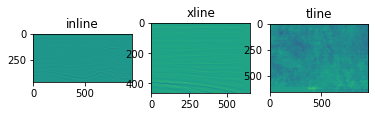

In [2]:


# plt different slices 
plot_random_directions(data, 100)

   

In [3]:
"""
We see that inline and xline directions have clear stacking patterns, 
but the tline is more meshy.

Intuitivly, we would could easily see more clear pattern change in iline/xline direction 
"""

'\nWe see that inline and xline directions have clear stacking patterns, \nbut the tline is more meshy.\n\nIntuitivly, we would could easily see more clear pattern change in iline/xline direction \n'

padding_needed {'inline': 53, 'xline': 9, 'tline': 50}
Found inline
Found xline
Found tline
padded_data (704, 960, 512)
padded_data (960, 704, 512)
padded_data (512, 960, 704)


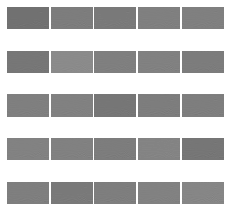

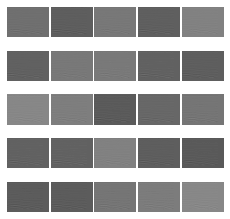

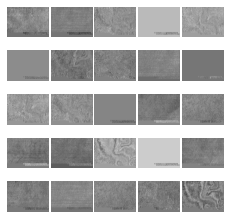

In [4]:
## We then pad each direction to be able to grid it to a 16, 32, 64 ++ grid. 
# The reason we choose such numbers are gupu optimilization (LINK)

# but beforre we can do this we need to pad the images to go up in the wanted patch size
patch_size = 64

padded_data = pad_data_to_fit_patch(data, patch_size, directions, num_samples, output_folder)
for dir in directions:
    print("padded_data", padded_data[dir].shape)
    
# plot supsets of each direction to visualize patterns in each direction
plot_subset_of_directions(padded_data, directions, 100)


In [5]:
# we have now padded all directions and can extract patched of patch_size 

patched_data, patched_labels, patched_labels_per_image, patched_labels_per_grid_cell, patched_labels_per_grid_cell, patched_grid_sizes, patched_num_smaples =  create_patched_data(padded_data, patch_size, directions)



dir shape (704, 960, 512)
nm 15 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [703. 703. 703. 703. 703. 703. 703. 703. 703. 703.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [110. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
dir shape (960, 704, 512)
nm 11 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [959. 959. 959. 959. 959. 959. 959. 959. 959. 959.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [78. 79. 80. 81. 82. 83. 84. 85. 86. 87.]
dir shape (512, 960, 704)
nm 15 11 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84

random_slice 60360
patched_slice (120, 64, 64)
random_slice 42064
patched_slice (88, 64, 64)
random_slice 58080
patched_slice (165, 64, 64)


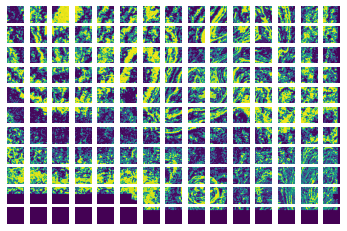

In [6]:
# plot random patches to verify

plot_patched_directions(padded_data, patched_data, patched_grid_sizes, patch_size, directions, output_folder)    
        

In [7]:
### Dimension reduction and visualization with PCA

In [12]:
from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

import numpy as np
import pandas as pd
K.clear_session()
np.random.seed(237)

direction = "inline"
print(patched_data[direction].shape)
data = np.expand_dims(patched_data[direction],axis=-1)
print(data.shape)
length = data.shape[0]//10
val_split = 0.1

# flatten data from (-1, patch_size, patch_size) to  (-1, 4064) 
data = data.reshape(patched_grid_sizes[direction][0], -1)
# find max abs value in data 
max_val = max(abs(np.min(data)),abs(np.max(data))) *0.7 # make sure to clipp sides 
print("abs max ",max_val) # --> outputs 127
# normalize between -1 and 1 
data = data/max_val 
# push first to get values between [0,2] and then devide by 2 to get values between [0,1)]
data = (data + 1) /2
data = np.clip(data, 0, 1)
print("MIN_MAX", np.min(data), np.max(data)) #--> outputs 0 and one 


# reshape to (-1, 64, 64)
data = data.reshape(-1, patch_size, patch_size)

(84480, 64, 64)
(84480, 64, 64, 1)
abs max  88.89999999999999
MIN_MAX 0.0 1.0


In [40]:
print(data.shape)

X_train = data[:1000]#data[:int(length*(1-val_split))]
X_valid = data[:100]#data[int(length*(1-val_split)):]
print(X_train.dtype, np.min(X_train), np.max(X_train))
# Normalize and reshape
X_train = X_train.astype('float32') #/ 255.
X_train = X_train.reshape(-1,patch_size,patch_size,1)

X_valid = X_valid.astype('float32') #/ 255.
X_valid = X_valid.reshape(-1,patch_size,patch_size,1)

print(X_train.shape, X_valid.shape )

(84480, 64, 64)
float64 0.0 1.0
(1000, 64, 64, 1) (100, 64, 64, 1)


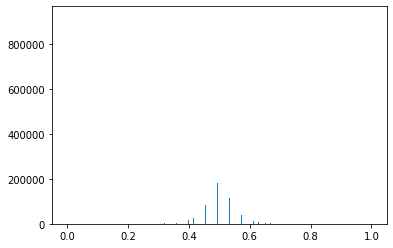

In [41]:
_ = plt.hist(X_train.flatten(), bins='auto')  # arguments are passed to np.histogram
plt.show()

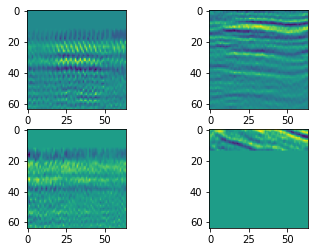

In [59]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[131][:,:,0])

plt.subplot(222)
plt.imshow(X_train[160][:,:,0])

plt.subplot(223)
plt.imshow(X_train[370][:,:,0])

plt.subplot(224)
plt.imshow(X_train[110][:,:,0])
plt.show()

In [60]:
img_shape = (patch_size, patch_size, 1)    # for MNIST
batch_size = 16
latent_dim = 512  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim, name="z_mu")(x)
z_log_sigma = layers.Dense(latent_dim, name="z_log_sigma")(x)



In [61]:
### B. Sampling function

In [62]:
# sampling function 
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

In [63]:
### C. Decoder network

In [64]:
print(shape_before_flattening[1:])
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = layers.Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)
decoder.summary()
# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)


(32, 32, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 65536)             33619968  
_________________________________________________________________
reshape_5 (Reshape)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 1)         289       
Total params: 33,638,721
Trainable params: 33,638,721
Non-trainable params: 0
_________________________________________________________________


In [65]:
### D. Loss
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [66]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_25 (Conv2D)               (None, 64, 64, 32)    320         input_10[0][0]                   
____________________________________________________________________________________________________
conv2d_26 (Conv2D)               (None, 32, 32, 64)    18496       conv2d_25[0][0]                  
____________________________________________________________________________________________________
conv2d_27 (Conv2D)               (None, 32, 32, 64)    36928       conv2d_26[0][0]                  
___________________________________________________________________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_5" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
# for loss diskussion see https://github.com/Lasagne/Recipes/issues/54
# loss nnot changing? https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing
# validating normilization 
print("MIN_MAX_X_train", np.min(X_train), np.max(X_train)) #--> must be [0,1] 
print("MIN_MAX_X_valid", np.min(X_valid), np.max(X_valid)) #--> must be [0,1] 

# start training
history = vae.fit(x=X_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(X_valid, None))

MIN_MAX_X_train 0.0 1.0
MIN_MAX_X_valid 0.0 1.0
Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 113s - loss: 0.6932 - val_loss: 0.6931
Epoch 2/10
1000/1000 [==============================] - 108s - loss: 0.6931 - val_loss: 0.6931
Epoch 3/10
1000/1000 [==============================] - 105s - loss: 0.6931 - val_loss: 0.6931
Epoch 4/10
1000/1000 [==============================] - 97s - loss: 0.6931 - val_loss: 0.6931
Epoch 5/10
1000/1000 [==============================] - 117s - loss: 0.6930 - val_loss: 0.6932
Epoch 6/10
1000/1000 [==============================] - 109s - loss: 0.6925 - val_loss: 0.6922
Epoch 7/10
1000/1000 [==============================] - 114s - loss: 0.6925 - val_loss: 0.6913
Epoch 8/10
1000/1000 [==============================] - 114s - loss: 0.6909 - val_loss: 0.6907
Epoch 9/10
1000/1000 [==============================] - 120s - loss: 0.6905 - val_loss: 0.6904
Epoch 10/10
1000/1000 [============================

In [53]:
# store model 
# serialize weights to HDF5
#filename ="/Users/anderskampenes/Documents/Dokumenter/NTNU/MASTER/code/notebooks/visualizing-seismic-using-a-variational-autoencoder"+"/model_2.h5"
#vae.save_weights(filename)
#print("Saved model to disk")

#vae.load_weights(filename)

print(history.history.keys())
print(history.history["loss"])



dict_keys(['val_loss', 'loss'])
[0.6931464953422546, 0.6931297221183776, 0.6931313152313232, 0.6931269707679748, 0.6931266889572144, 0.6931238737106323, 0.6931241273880004, 0.6931211123466492, 0.6931235399246216, 0.6931205706596375]


In [54]:
# X's and Y's
print("Making sure the data is normalzed", np.min(X_train), np.max(X_train))
X_valid_noTest = X_train[:100]
y_valid_noTest = patched_labels_per_image[direction][:100]
print(X_valid_noTest.shape)


Making sure the data is normalzed 0.0 1.0
(100, 64, 64, 1)


img samples  0.29752532 0.6799775
img samples  0.4807753 0.5193746
img samples  0.48916692 0.51043093
(5, 64, 64, 1) (5, 64, 64, 1)


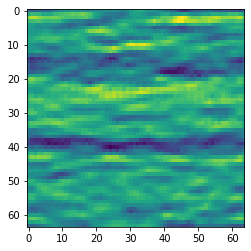

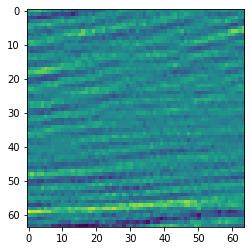

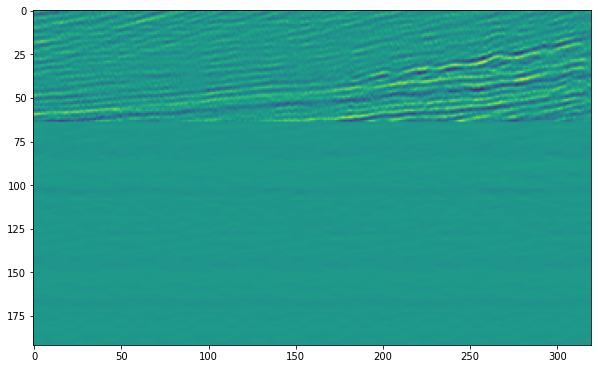

In [58]:
encoder = Model(input_img, z_mu)
vaeeee = Model(input_img, z_decoded)

num_imgs = 5
img_samples = X_train[50:50+num_imgs]
print("img samples ", np.min(img_samples), np.max(img_samples))
#run vae through some of them 
reconstructions_vae = vaeeee.predict(img_samples)
reconstructions_enc_dec =decoder.predict(encoder.predict(img_samples))
print("img samples ", np.min(reconstructions_vae), np.max(reconstructions_vae))
print("img samples ", np.min(reconstructions_enc_dec), np.max(reconstructions_enc_dec))

print(reconstructions_vae.shape, reconstructions_enc_dec.shape)

plt.imshow(decoder.predict(encoder.predict(img_samples))[0][:,:,0])
plt.show()
plt.imshow(img_samples[0][:,:,0])
plt.show()

rec_list = [img_samples, reconstructions_vae, reconstructions_enc_dec]
figure = np.zeros((patch_size * len(rec_list), patch_size * num_imgs))
for i, rec_type in enumerate(rec_list):
    for j in range(num_imgs):
        x_decoded = rec_type[j]
        img = rec_type[j][:,:,0]
        figure[i * patch_size: (i + 1) * patch_size,
               j * patch_size: (j + 1) * patch_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()  
#plt.imshow(reconstructions[5].reshape(patch_size, patch_size))
#plt.show()


(20, 28, 28, 1)


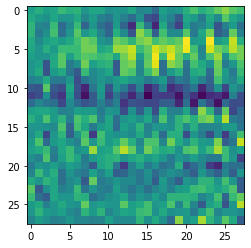

(20, 28, 28, 1)
(20, 2)
(20, 28, 28, 1)


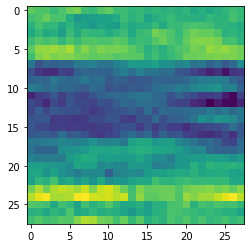

In [26]:


img_samples = X_train[2356:2376]
print(img_samples.shape)
plt.imshow(img_samples[10][:,:,0])
plt.show()
print(img_samples.shape)
img_encoded = encoder.predict(img_samples)
print(img_encoded.shape)
img_decoded = decoder.predict(img_encoded)
print(img_decoded.shape)
plt.imshow(img_decoded[10][:,:,0])


In [60]:
# Display a 2D manifold of the digits
n = 20  # figure with 20x20 digits
digit_size = patch_size
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()  

ValueError: Error when checking : expected input_7 to have shape (None, 16) but got array with shape (16, 2)

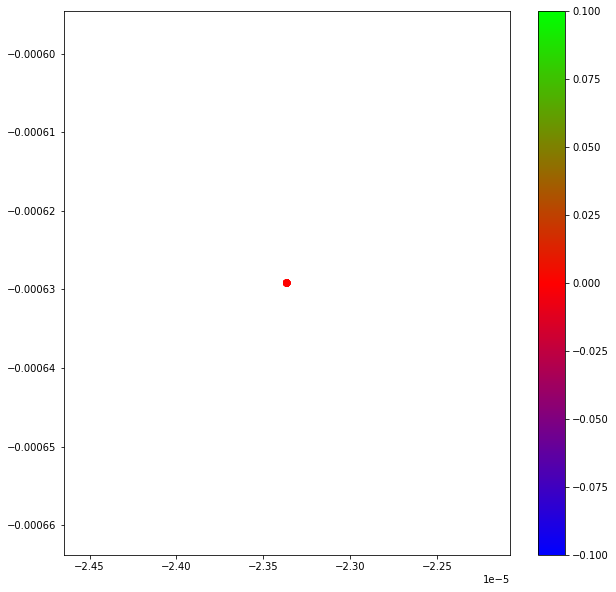

In [30]:
# Translate into the latent space  by plotting the MEAN
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(X_valid_noTest, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_valid_noTest, cmap='brg')
plt.colorbar()
plt.show()



In [61]:

# plot random images in the space 
z_samples = np.asarray([[-3,-2],[-3,1],[0,2],[0,0],[-2,-4],[0,-4], [2,-3]])
images = np.squeeze(decoder.predict(z_samples))
print("images.shape", images.shape)

from matplotlib import offsetbox

def plot_components(proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(proj.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i].T, cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            
            
plot_components(proj=z_samples,images=[np.reshape(i, (patch_size, patch_size)).T for i in images])






ValueError: Error when checking : expected input_7 to have shape (None, 16) but got array with shape (7, 2)

images.shape (7, 28, 28)


NameError: name 'xx' is not defined